In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re

main_folder = Path('.')

# Make an empty list to store dataframes
all_dataframes = []

# Loop through all subfolders within the main folder
for subfolder in main_folder.iterdir():
    if subfolder.is_dir():
        # Loop through all CSV files within the subfolder
        for csv_file in subfolder.glob('*.csv'):  # Find all CSV files in the folder
            try:
                # Load only the first two columns of each CSV file
                df = pd.read_csv(csv_file, encoding='ISO-8859-1', skiprows=44, usecols=[0, 1], names=['Frequency', 'Amplitude'])
            except Exception as e:
                print(f"Error reading {csv_file}: {e}") # Skip to the next file if there's an error
                continue 

            # Add metadata columns for tracking
            df['source_folder'] = subfolder.name
            df['source_folder_label'] = subfolder.name.replace('_', ' ')
            df['source_file'] = csv_file.stem[5:-11]  # Remove 'RunX_' prefix and '.csv' suffix
            df['source_file_label'] = csv_file.stem[5:-11].replace('_', ' ')
            
            # Append the dataframe to the list
            all_dataframes.append(df)

# Concatenate all the dataframes into one dataframe
combined_df = pd.concat(all_dataframes, ignore_index=True)

# Display combined dataframe to check structure
print(combined_df)

        Frequency  Amplitude   source_folder source_folder_label  \
0           20000 -63.819308  Part_B_LOG_PWR      Part B LOG PWR   
1           40000 -74.946919  Part_B_LOG_PWR      Part B LOG PWR   
2           60000 -73.143995  Part_B_LOG_PWR      Part B LOG PWR   
3           80000 -73.627693  Part_B_LOG_PWR      Part B LOG PWR   
4          100000 -74.521644  Part_B_LOG_PWR      Part B LOG PWR   
...           ...        ...             ...                 ...   
18011  2569920000 -94.382634      Part_B_PWR          Part B PWR   
18012  2569940000 -94.473433      Part_B_PWR          Part B PWR   
18013  2569960000 -94.168152      Part_B_PWR          Part B PWR   
18014  2569980000 -94.319008      Part_B_PWR          Part B PWR   
18015  2570000000 -94.384161      Part_B_PWR          Part B PWR   

                 source_file      source_file_label  
0               10MHz_-25dBm           10MHz -25dBm  
1               10MHz_-25dBm           10MHz -25dBm  
2               10MHz

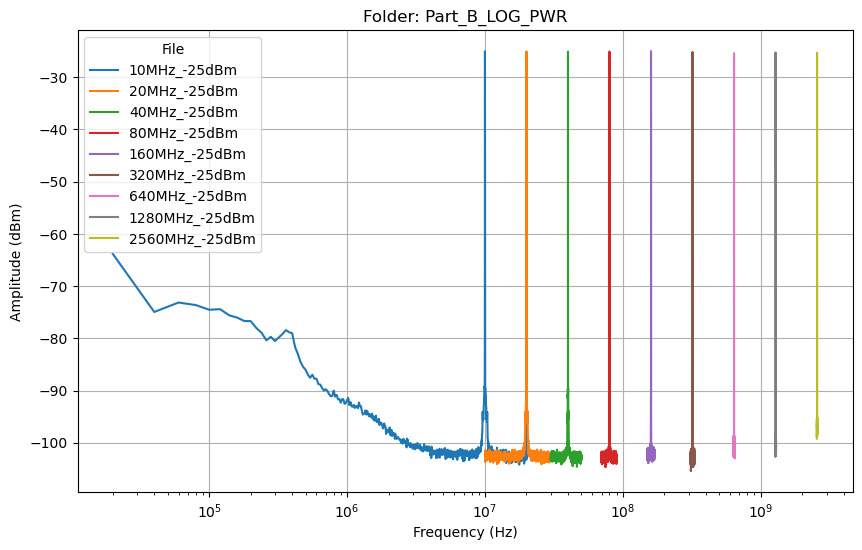

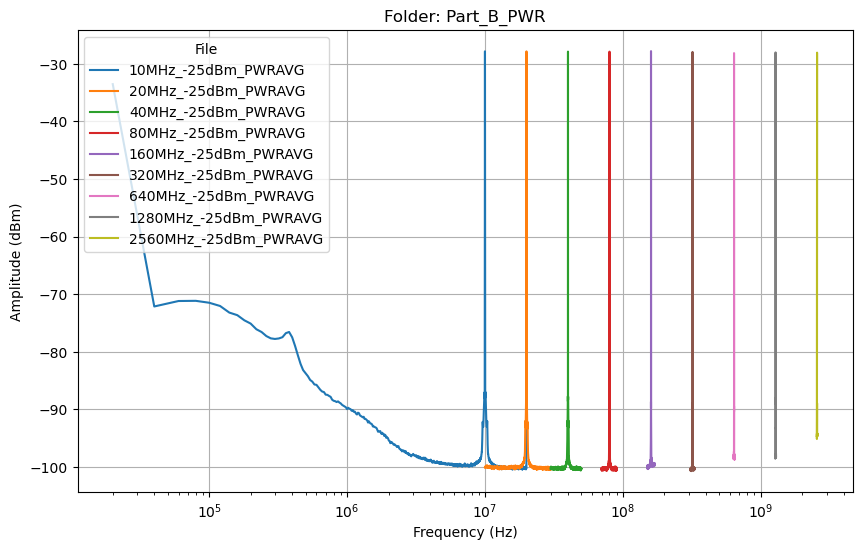

In [84]:
# Group by the source_folder
for folder_name, folder_df in combined_df.groupby('source_folder'):
    plt.figure(figsize=(10, 6))
    
    # Get unique file names and sort them numerically based on frequency
    unique_files = folder_df['source_file'].unique()
    
    # Function to extract numeric value for sorting
    def extract_numeric(filename):
        match = re.search(r'(\d+)', filename)  # Find the first sequence of digits
        return int(match.group(0)) if match else float('inf')  # Return a large number if no digits found

    # Sort files using the extract_numeric function
    sorted_files = sorted(unique_files, key=extract_numeric)

    # Plot each unique file within the folder on the same figure
    for file_name in sorted_files:
        file_df = folder_df[folder_df['source_file'] == file_name]
        
        # Assume the first column is frequency and the second is amplitude
        plt.plot(file_df.iloc[:, 0], file_df.iloc[:, 1], label=file_name)
        
    # Set logarithmic scale for the x-axis
    plt.xscale('log')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude (dBm)')
    plt.title(f'Folder: {folder_name}')
    plt.legend(title='File')
    plt.grid(True)
    plt.show()


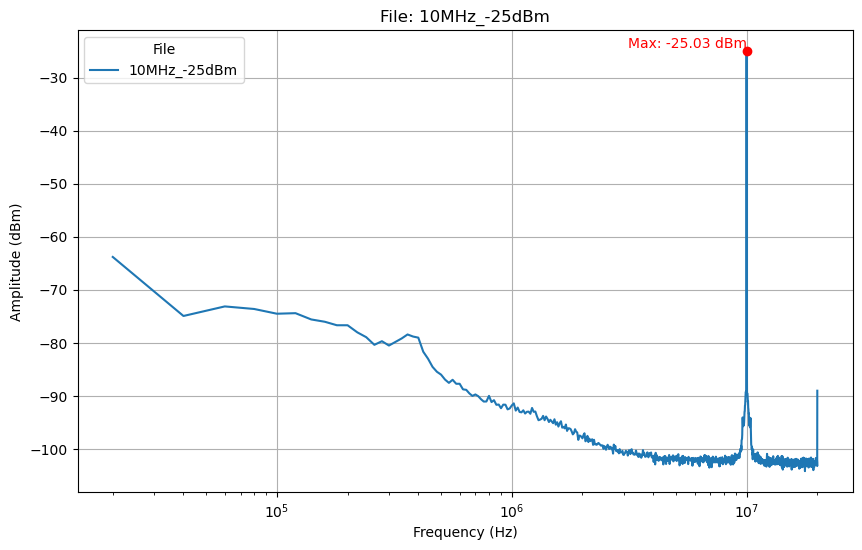

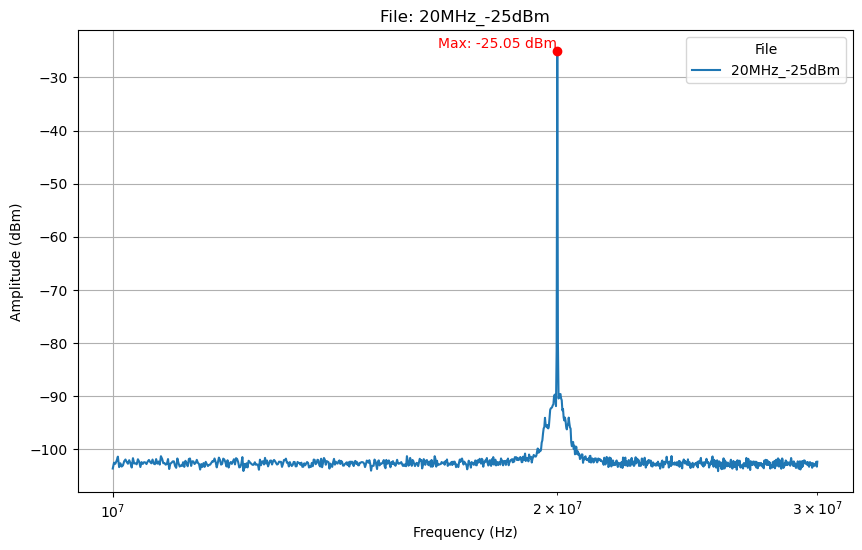

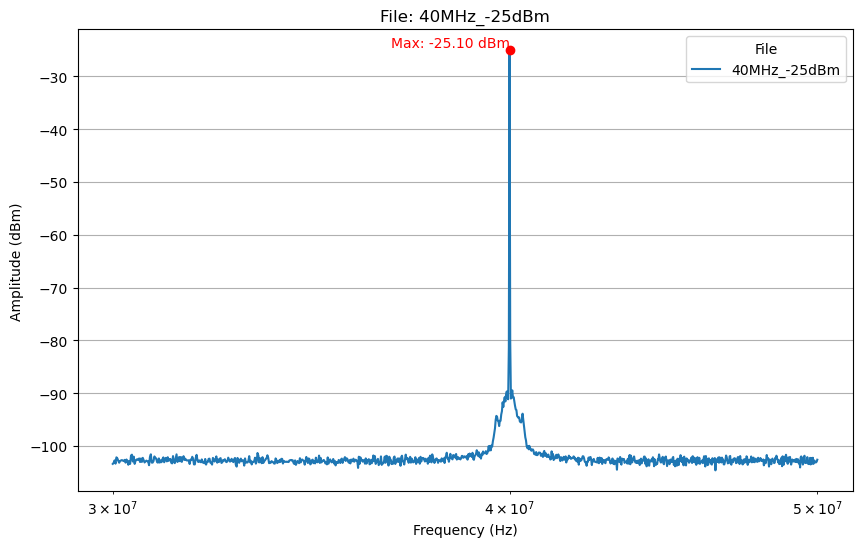

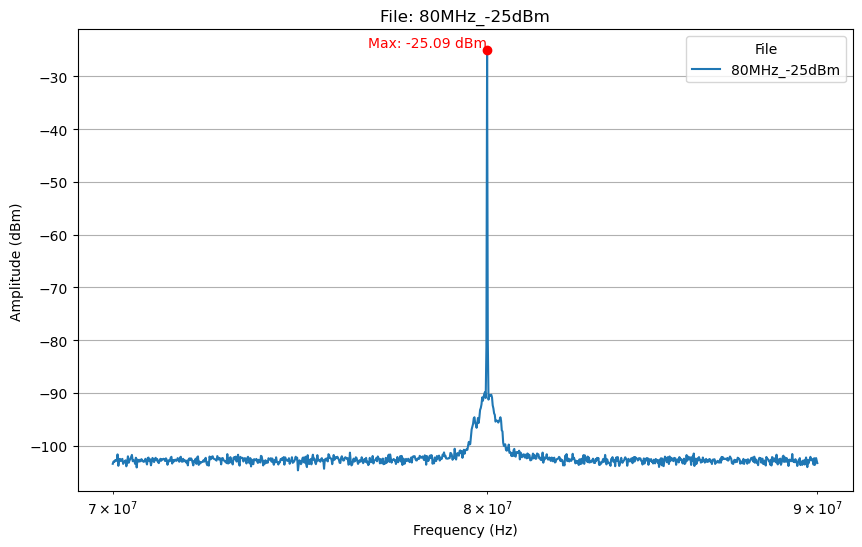

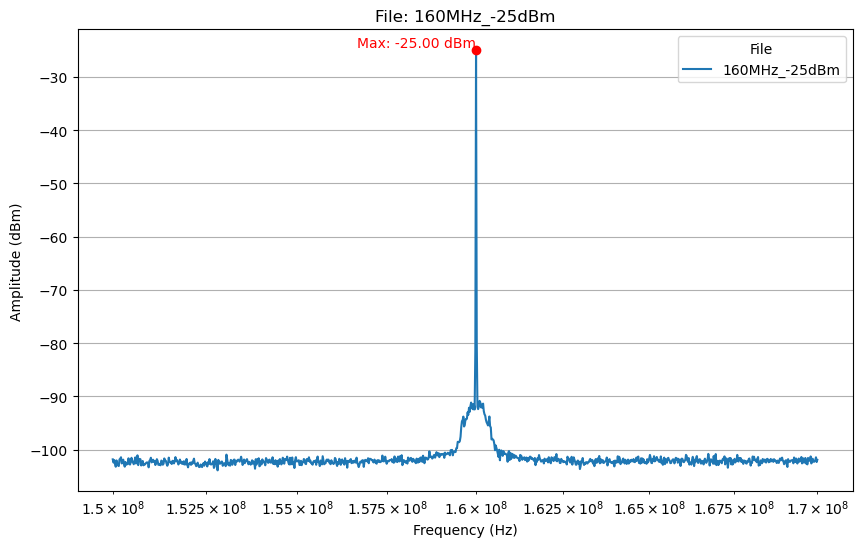

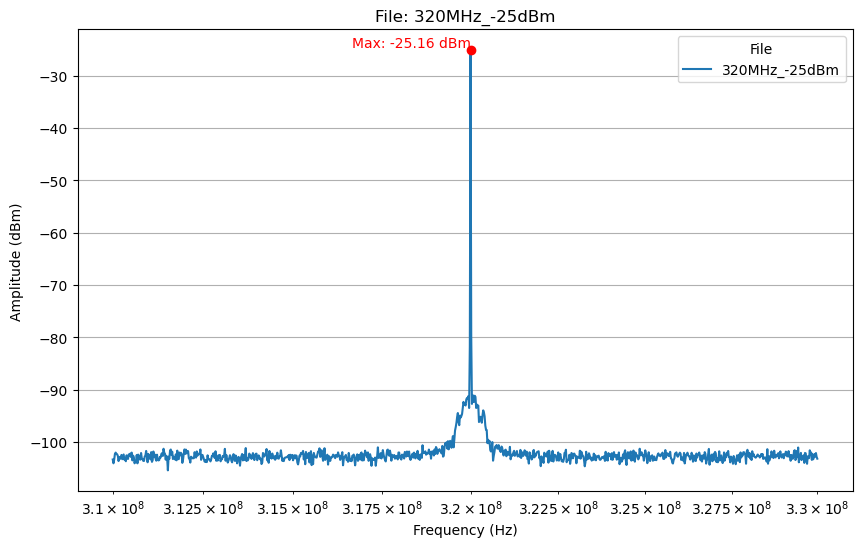

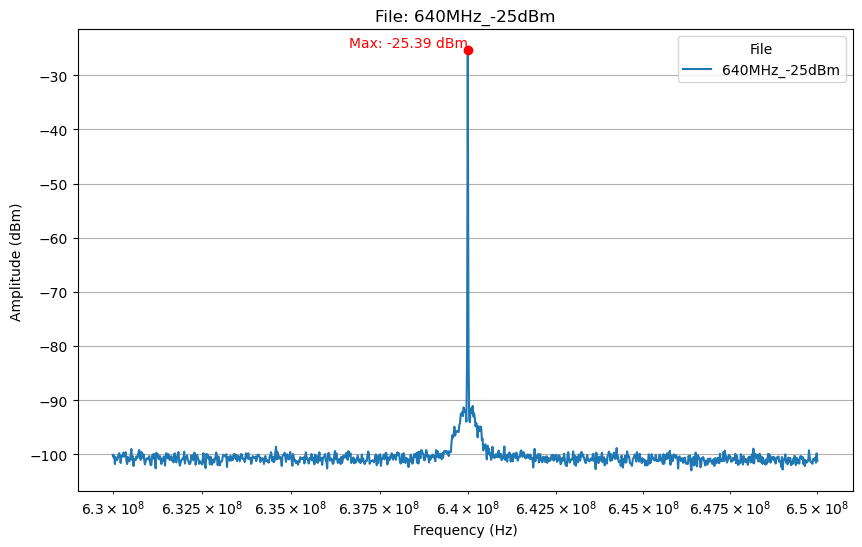

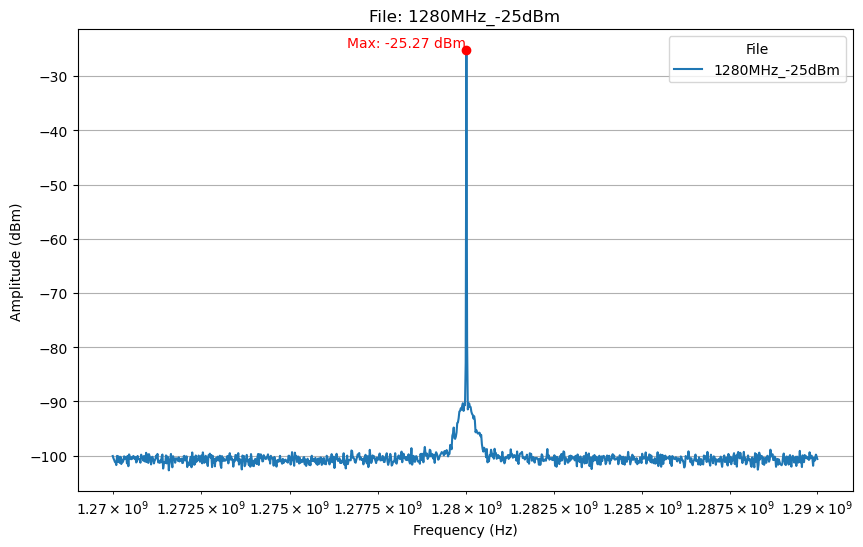

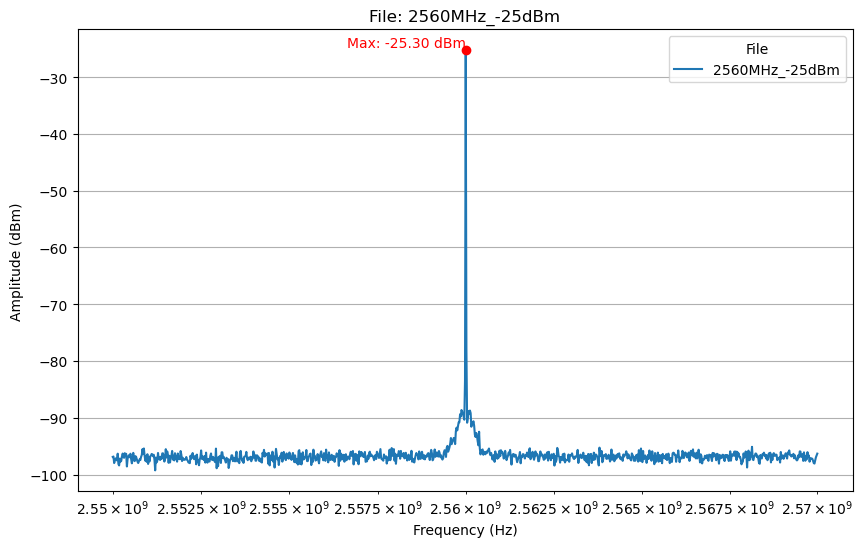

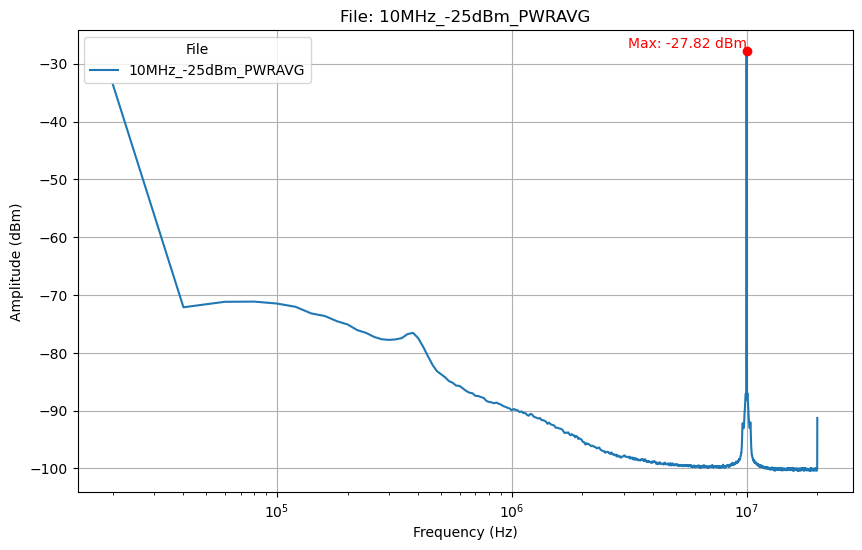

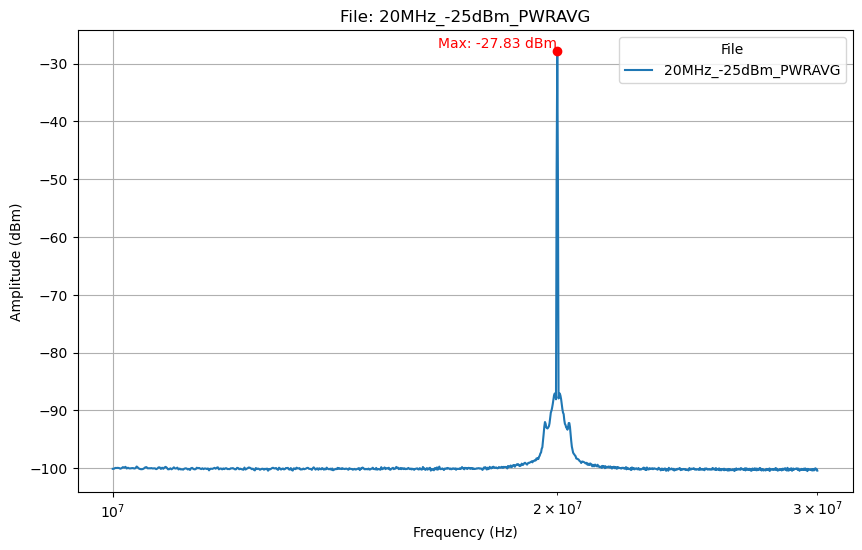

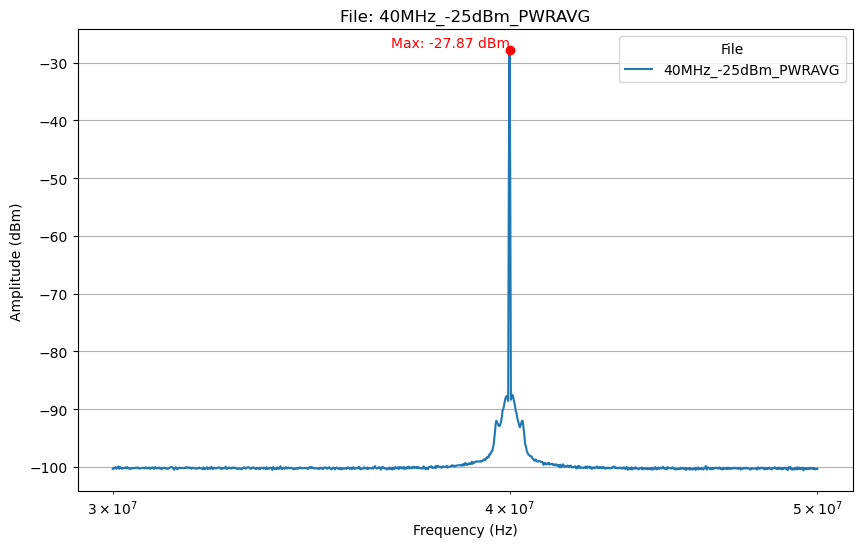

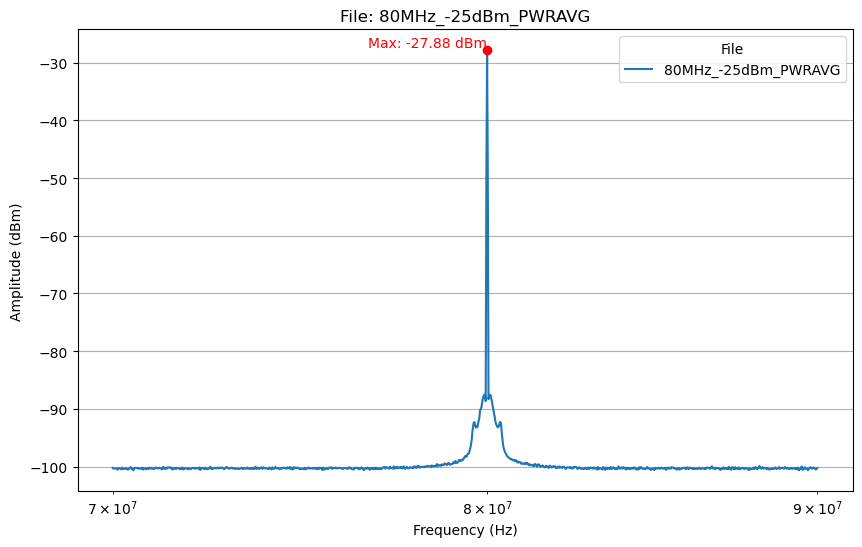

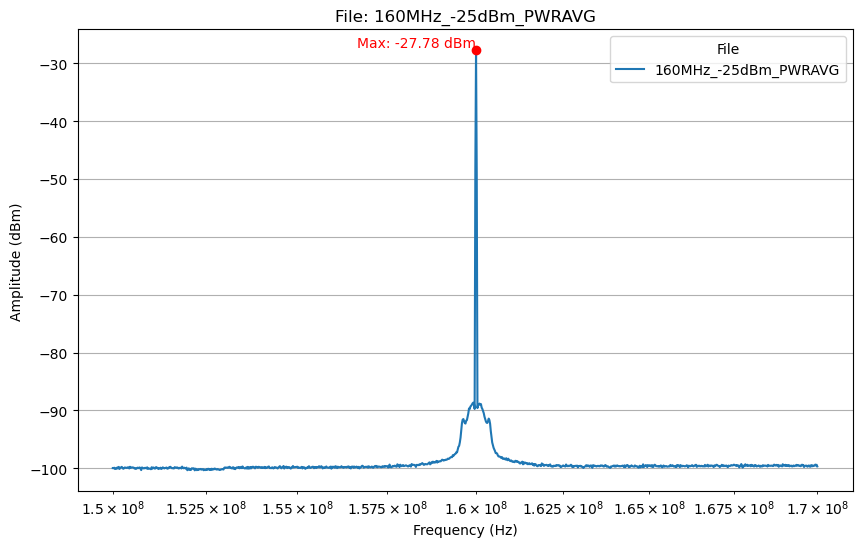

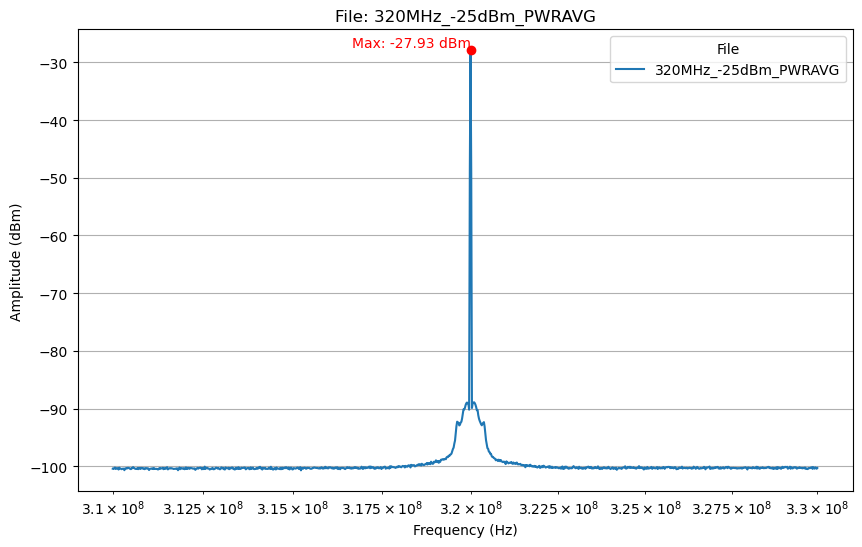

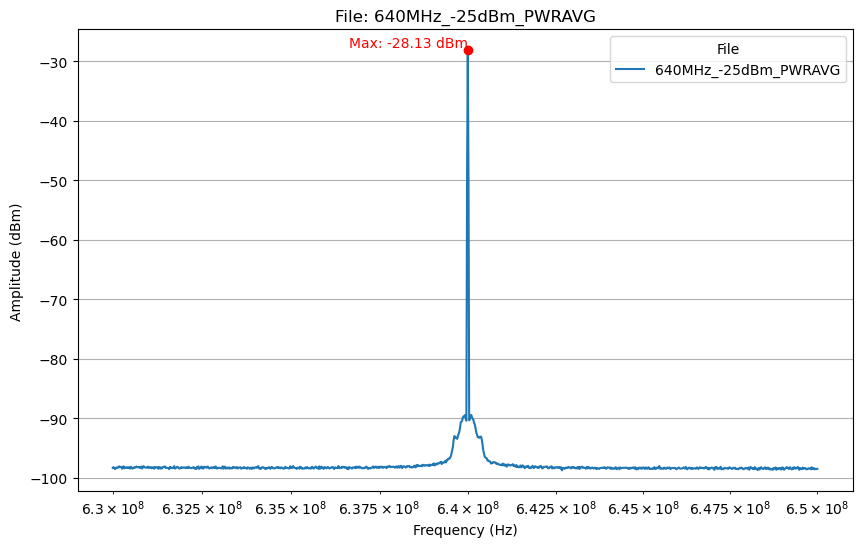

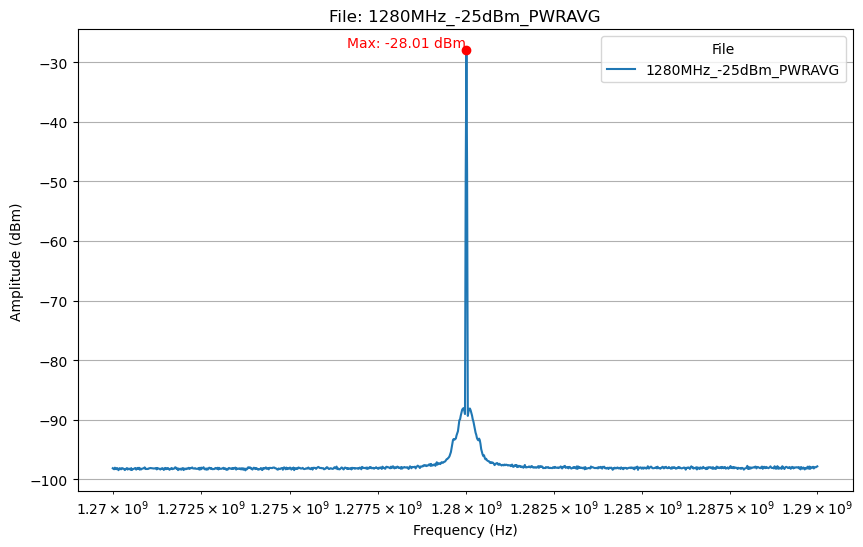

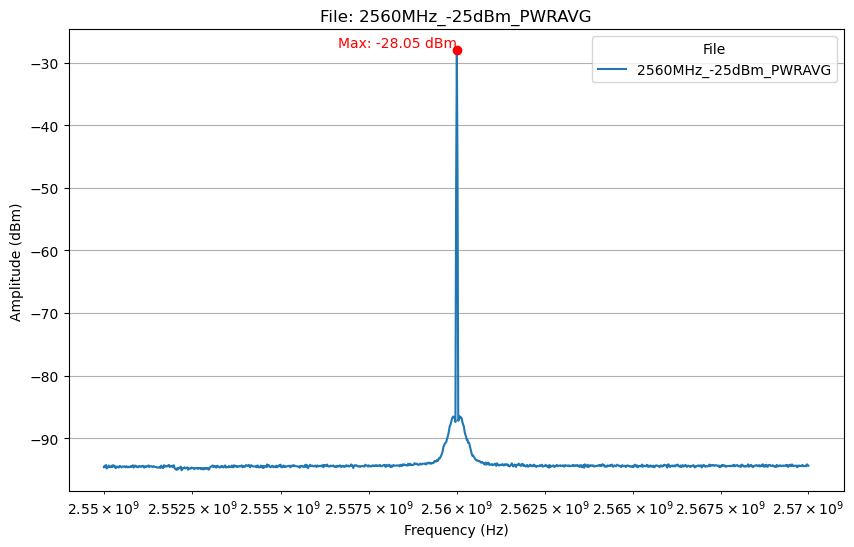

Max Amplitudes by Folder: {'Part_B_LOG_PWR': [-25.02633989, -25.0544357021678, -25.1009102389144, -25.0850200853517, -24.9993030465328, -25.1594160973085, -25.3918948086853, -25.2697717058519, -25.2990154801153], 'Part_B_PWR': [-27.82101585, -27.8310364635169, -27.8706171071171, -27.8771689616607, -27.7842879253638, -27.9261190010125, -28.1306869448569, -28.0094040815859, -28.0504598329595]}
Frequencies by Folder: {'Part_B_LOG_PWR': [10000000, 20000000, 40000000, 80000000, 160000000, 320000000, 640000000, 1280000000, 2560000000], 'Part_B_PWR': [10000000, 20000000, 40000000, 80000000, 160000000, 320000000, 640000000, 1280000000, 2560000000]}


In [85]:
# Create a dictionary to hold lists for each source folder
max_amplitudes_by_folder = {}
frequencies_by_folder = {}

# Get unique file names from the DataFrame
unique_files = combined_df['source_file'].unique()

# Plot each file individually and show the maximum superimposed
for file_name in unique_files:
    # Filter the DataFrame for the current file
    file_df = combined_df[combined_df['source_file'] == file_name].reset_index(drop=True)
    
    # Ensure that file_df is not empty and has at least 2 columns
    if not file_df.empty and file_df.shape[1] >= 2:
        
        # Get the source folder for the current file
        source_folder = file_df['source_folder'].iloc[0]

        # Initialize lists for the folder if not already present
        if source_folder not in max_amplitudes_by_folder:
            max_amplitudes_by_folder[source_folder] = []
            frequencies_by_folder[source_folder] = []

        plt.figure(figsize=(10, 6))
        
        # Plot the frequency vs. amplitude for the current file
        plt.plot(file_df.iloc[:, 0], file_df.iloc[:, 1], label=file_name)
        
        # Find the maximum amplitude and its corresponding index
        max_amplitude = file_df.iloc[:, 1].max()  # Get the max amplitude value
        max_index = file_df.iloc[:, 1].idxmax()  # Get the index of the max amplitude

        # Now get the corresponding frequency using the safe index
        max_freq = file_df.iloc[max_index, 0]  # Get the corresponding frequency

        # Store the max amplitude and its corresponding frequency in the appropriate folder lists
        max_amplitudes_by_folder[source_folder].append(max_amplitude)
        frequencies_by_folder[source_folder].append(max_freq)

        # Superimpose the maximum point
        plt.plot(max_freq, max_amplitude, 'ro')  # Red circle for the max point
        plt.text(max_freq, max_amplitude, f'Max: {max_amplitude:.2f} dBm', 
                 ha='right', va='bottom', color='red', fontsize=10)
        
        # Set logarithmic scale for the x-axis
        plt.xscale('log')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Amplitude (dBm)')
        plt.title(f'File: {file_name}')
        plt.legend(title='File')
        plt.grid(True)
        plt.show()
    else:
        print(f"Skipping file '{file_name}' because it is empty or does not have enough columns.")

# After processing all files, you can access the stored maximum amplitudes and frequencies
print("Max Amplitudes by Folder:", max_amplitudes_by_folder)
print("Frequencies by Folder:", frequencies_by_folder)

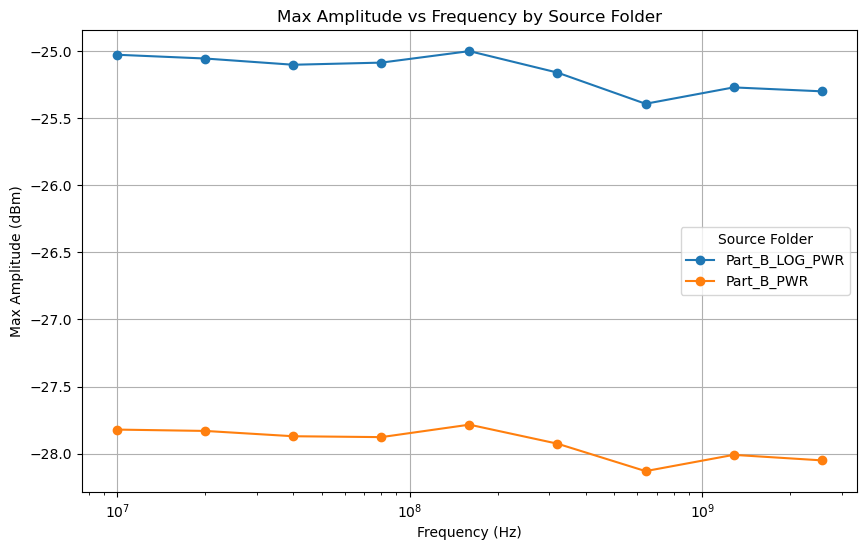

In [86]:
# Create a figure for the plot
plt.figure(figsize=(10, 6))

# Iterate over each source folder and plot the corresponding max amplitudes vs frequencies
for source_folder in max_amplitudes_by_folder.keys():
    max_amplitudes = max_amplitudes_by_folder[source_folder]
    frequencies = frequencies_by_folder[source_folder]

    # Plot each folder's max amplitude vs. frequency as a line
    plt.plot(frequencies, max_amplitudes, marker='o', label=source_folder)

# Customize the plot
plt.xscale('log')  # Set the x-axis to logarithmic scale
plt.xlabel('Frequency (Hz)')
plt.ylabel('Max Amplitude (dBm)')
plt.title('Max Amplitude vs Frequency by Source Folder')
plt.legend(title='Source Folder')
plt.grid(True)

# Show the plot
plt.show()